In [4]:
import yaml
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as TVDatasets

import torch_geometric
from torch_geometric.data import Data as GraphData 

from torch_geometric.nn import GCNConv, GATConv, APPNP, SAGEConv
from torch_geometric.nn.models.label_prop import LabelPropagation
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx

from sklearn.metrics import classification_report
# from sklearn.calibration import CalibrationDisplay

from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import matplotlib as mpl
# Use the pgf backend (must be done before import pyplot interface)
mpl.use('pgf')
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    # "text.usetex": True,     # use inline math for ticks
    # "pgf.rcfonts": False     # don't setup fonts from rc parameters
    })

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Torch is running on {device}")


import sys
from gnn_cp.data.data_manager import GraphDataManager
from gnn_cp.models.graph_models import GCN, GAT, APPNPNet, SAGE
from gnn_cp.models.model_manager import GraphModelManager
from gnn_cp.data.utils import make_dataset_instances
import gnn_cp.cp.transformations as cp_t
import gnn_cp.cp.graph_transformations as cp_gt
from gnn_cp.cp.graph_cp import GraphCP

Torch is running on cuda
Torch Graph Models are running on cuda
Torch Graph Models are running on cuda
Torch Graph Models are running on cuda
Torch Graph Models are running on cuda


In [5]:
config_file_dir = "../baselines/config.yaml"
results_dir = "../baselines/results"
figures_dir = "./result-storage"
fair_network_results = os.path.join(figures_dir, "fair-network-results")

In [6]:
# loading the baseline settings
with open(config_file_dir, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
general_dataset_config = config.get("baseline", {}).get("general_dataset_config", {})


assert os.path.isdir(results_dir), "The results path does not exist!"

models_cache_dir = os.path.join(results_dir, "models")
assert os.path.isdir(models_cache_dir), "Directory to trained models is not found! Maybe first tun the make_baselines.py file"
data_dir = os.path.join(results_dir, "datasets")
assert os.path.isdir(data_dir), "Directory to Data Files is not found!"
splits_dir = os.path.join(results_dir, "splits")
assert os.path.isdir(splits_dir), "Directory to Data Splits is not found!"

dataset_names = list(config.get("baseline", {}).get("datasets", {}).keys())
models_config = config.get("baseline", {}).get("models", {})
model_classes = list(models_config.keys())

# Making a directory to store results for CPs
cp_results_dir = os.path.join(results_dir, "cp_results")
if not os.path.isdir(cp_results_dir):
    os.mkdir(cp_results_dir)


# region
# Making dataset-split and model instances
dataset_str_list = '\n'.join([f'{i}: {dataset_name}' for i, dataset_name in enumerate(dataset_names)])
dataset_name_idx = int(input(f"specify the dataset index:\n{dataset_str_list}\n"))
dataset_key = dataset_names[int(dataset_name_idx)]

model_str_list = '\n'.join([f'{i}: {model_name}' for i, model_name in enumerate(model_classes)])
model_class_idx = int(input(f"specify the model index:\n{model_str_list}\n"))
model_class_name = model_classes[model_class_idx]

dataset_manager = GraphDataManager(data_dir, splits_dir)
dataset = dataset_manager.get_dataset_from_key(dataset_key).data

print(f"dataset = {dataset_key}")
instances = make_dataset_instances(data_dir, splits_dir, models_cache_dir, dataset_key, model_class_name, models_config)

instances_accuracy = [instance["accuracy"] for instance in instances]
print(f"acc={np.mean(instances_accuracy)} +- {np.std(instances_accuracy)}")
best_model_accuracy = np.max(instances_accuracy)

instances_logits = [
    instance["model"].predict(dataset) for instance in instances
]

specify the dataset index:
0: cora_ml
1: pubmed
2: citeseer
3: coauthor_cs
4: coauthor_physics
5: amazon_computers
6: amazon_photo
 0
specify the model index:
0: GCN
1: GAT
2: SAGE
3: MLP
4: APPNPNet
 0


dataset = cora_ml
Dataset Loaded Successfully!
Following labeled splits:
class 0: train=20, val=20
class 1: train=20, val=20
class 2: train=20, val=20
class 3: train=20, val=20
class 4: train=20, val=20
class 5: train=20, val=20
class 6: train=20, val=20
Loading Models
Loading Models GCN
Accuracy: 0.8231307550644568 +- 0.009074238748131642
acc=0.8231307550644568 +- 0.009074238748131642


In [7]:
# make_inductive_subgraph
train_idx = instances[0]["train_idx"]
val_idx = instances[0]["val_idx"]
test_idx = instances[0]["test_idx"]
idx = torch.concat([train_idx, val_idx]).to(device)


In [8]:
def make_subgraph(dataset, idx):
    new_edge_index = dataset.edge_index.clone()
    remaining_edge = torch.isin(new_edge_index[0], idx) & torch.isin(new_edge_index[1], idx)
    new_edge_index = new_edge_index[:, remaining_edge]
    return torch_geometric.data.Data(x=dataset.x.clone(), y=dataset.y.clone(), edge_index=new_edge_index)

In [9]:
make_subgraph(dataset, idx)

Data(x=[2995, 2879], edge_index=[2, 156], y=[2995])

In [10]:
model = instances[0]["model"]

In [11]:
model_hparams = models_config.get(model_class_name, {}).get("config", {})
optimizer_hparams = models_config.get(model_class_name, {}).get("optimizer", {})
model_hparams.update({"n_features": dataset.x.shape[1], "n_classes": dataset.y.max().item() + 1})

model_class = GCN

lr = optimizer_hparams.get("lr", 0.01)
weight_decay = optimizer_hparams.get("weight_decay", 0.0)

inductive_model=GraphModelManager(
    model=model_class(**model_hparams), 
    optimizer_lambda=lambda model_params: torch.optim.Adam(model_params, lr=lr, weight_decay=weight_decay),
    checkpoint_address=os.path.join(figures_dir, "temp-models"), model_name=f"{dataset_key}-{model_class.__name__}-inductive")
transductive_model = GraphModelManager(
    model=model_class(**model_hparams), 
    optimizer_lambda=lambda model_params: torch.optim.Adam(model_params, lr=lr, weight_decay=weight_decay),
    checkpoint_address=os.path.join(figures_dir, "temp-models"), model_name=f"{dataset_key}-{model_class.__name__}-transductive")

In [12]:
inductive_dataset = make_subgraph(dataset, torch.concat([train_idx, val_idx]).to(device))
_, _ = inductive_model.fit(inductive_dataset, training_idx=train_idx, validation_idx=val_idx)
inductive_model.prediction_evaluation(dataset, test_idx)

WarmUP:: training: epoch = 0 --> training loss = 1.958130955696106 validation loss = 1.970584511756897
WarmUP:: training: epoch = 10 --> training loss = 0.5591351389884949 validation loss = 1.4666944742202759
WarmUP:: training: epoch = 20 --> training loss = 0.32202696800231934 validation loss = 1.548492193222046
WarmUP:: training: epoch = 30 --> training loss = 0.16955237090587616 validation loss = 1.9021785259246826
WarmUP:: training: epoch = 40 --> training loss = 0.19847632944583893 validation loss = 1.6123126745224
training: epoch = 0 --> training loss = 0.18514230847358704 validation loss = 1.7933101654052734
Early stopping on epoch 9
              precision    recall  f1-score   support

           0       0.88      0.61      0.72       314
           1       0.59      0.80      0.68       362
           2       0.92      0.94      0.93       412
           3       0.84      0.77      0.80       402
           4       0.93      0.77      0.84       817
           5       0.48   

In [13]:
_, _ = transductive_model.fit(dataset, training_idx=train_idx, validation_idx=val_idx)
transductive_model.prediction_evaluation(dataset, test_idx)

WarmUP:: training: epoch = 0 --> training loss = 1.9641666412353516 validation loss = 1.9575316905975342
WarmUP:: training: epoch = 10 --> training loss = 0.160768061876297 validation loss = 0.6955124735832214
WarmUP:: training: epoch = 20 --> training loss = 0.04314013570547104 validation loss = 0.5579366683959961
WarmUP:: training: epoch = 30 --> training loss = 0.03106953762471676 validation loss = 0.6418554782867432
WarmUP:: training: epoch = 40 --> training loss = 0.0218284260481596 validation loss = 0.6091655492782593
training: epoch = 0 --> training loss = 0.05775865912437439 validation loss = 0.6518659591674805
Early stopping on epoch 9
              precision    recall  f1-score   support

           0       0.91      0.68      0.78       314
           1       0.67      0.73      0.70       362
           2       0.94      0.90      0.92       412
           3       0.82      0.85      0.83       402
           4       0.90      0.81      0.86       817
           5       0.5

In [14]:
tuning_fraction = np.round(instances[0]["train_idx"].shape[0] / instances[0]["test_idx"].shape[0], 3)

lambda_vals = np.arange(0, 1.01, 0.01).round(3)
accuracy = 0.82
coverage_values = np.arange(start=np.round(accuracy, 2), stop=0.97, step=0.01).round(3)
fixed_neigh_coef = 0.6
selected_coverage = coverage_values[len(coverage_values)//2]


def singleton_hit(pred_set, true_mask):
    one_sized_pred = (pred_set.sum(axis=1) == 1)
    result = pred_set[true_mask][one_sized_pred].sum().item() / pred_set.shape[0]
    return result

singleton_hit_metric = lambda pred_set, true_mask: singleton_hit(pred_set, true_mask)
set_size_metric = lambda pred_set, true_mask: GraphCP.average_set_size(pred_set)
coverage_metric = lambda pred_set, true_mask: GraphCP.coverage(pred_set, true_mask)
argmax_accuracy = lambda pred_set, true_mask: GraphCP.argmax_accuracy(pred_set, true_mask)

metrics_dict = {
    "empi_coverage": coverage_metric,
    "average_set_size": set_size_metric,
    "singleton_hit": singleton_hit_metric
}

k_reg_range = np.arange(0, dataset.y.max().cpu().numpy(), 1).astype(int)
penalty_range = np.arange(0, 5.01, 0.01).round(3)

pivot_coverages = np.array([(1 + accuracy * 2) / 3, (1 + accuracy) / 2, (2 + accuracy) / 3]).round(2)

In [15]:
def compute_tune_calib_fraction(instance):
    tune_fraction = np.round(instance["train_idx"].shape[0] / instance["test_idx"].shape[0], 3)
    calib_fraction = np.round(instance["train_idx"].shape[0] / (instance["test_idx"].shape[0] - instance["train_idx"].shape[0]), 3)
    return tune_fraction, calib_fraction

def tune_truetest_split(test_idx, dataset, tuning_fraction):
    te_idx, tu_idx, _, _ = dataset_manager.train_test_split(test_idx, dataset.y[test_idx], training_fraction=tuning_fraction)
    return te_idx, tu_idx

In [13]:
instance_idx = 0
instance = instances[instance_idx]

def fair_shuffle_test_multiple_metrics(
    scores, y_true_mask, coverage_guarantee=0.92,
    n_iters=10, 
    metrics_dict={"set_size": lambda pred_set, true_mask: GraphCP.average_set_size(pred_set),
                  "coverage": lambda pred_set, true_mask: GraphCP.coverage(pred_set, true_mask),
                  "argmax_accuracy": lambda pred_set, true_mask: GraphCP.argmax_accuracy(pred_set, true_mask)},
    calib_fraction=0.5, tune_scores=None, tune_mask=None):
    
    result_df = []
    for iter_idx in range(n_iters):
        iteration_series = pd.Series({"attempt": iter_idx})
        calib_scores_sub, eval_scores, calib_ymask_sub, eval_ymask = GraphDataManager.train_test_split(
            scores, y_true_mask, training_fraction=calib_fraction, return_idx=False)
        calib_scores = calib_scores_sub if tune_scores is None else torch.concat([calib_scores_sub, tune_scores])
        calib_ymask = calib_ymask_sub if tune_mask is None else torch.concat([calib_ymask_sub, tune_mask])
        scores_quantile = GraphCP(transformation_sequence=[], coverage_guarantee=coverage_guarantee).calibrate_from_scores(calib_scores, calib_ymask)
        pred_set = eval_scores > scores_quantile
        for metric_name, metric_func in metrics_dict.items():
            result_val = metric_func(pred_set, eval_ymask)
            iteration_series[metric_name] = result_val
        result_df.append(iteration_series)

    result_df = pd.DataFrame(result_df)
    return result_df

# preparing first ingrediant of CP
def compare_cps(instance, dataset, coverage_val, lambda_val, k_reg, penalty, calib_fraction, true_test_idx, n_iters=100):
    train_idx, val_idx, _ = instance["train_idx"], instance["val_idx"], instance["test_idx"]
    test_idx = true_test_idx
    model = instance["model"]
    tune_fraction, calib_fraction = compute_tune_calib_fraction(instance)
    label_mask = F.one_hot(dataset.y).bool()
    logits = model.predict(dataset, return_embeddings=True)

    baseline_cp = GraphCP(transformation_sequence=[cp_t.APSTransformation(softmax=True)])

    baseline_scores = baseline_cp.get_scores_from_logits(logits)
    baseline_result = GraphCP([], coverage_guarantee=coverage_val).shuffle_test_multiple_metrics(baseline_scores[test_idx], label_mask[test_idx], metrics_dict=metrics_dict, calib_fraction=calib_fraction, n_iters=n_iters)

    regular_scores = cp_t.RegularizerPenalty(k_reg=k_reg, penalty=penalty).pipe_transform(baseline_scores)
    regular_result = GraphCP([], coverage_guarantee=coverage_val).shuffle_test_multiple_metrics(regular_scores[test_idx], label_mask[test_idx], metrics_dict=metrics_dict, calib_fraction=calib_fraction, n_iters=n_iters)

    mixed_scores = cp_gt.VertexMPTransformation(neigh_coef=lambda_val, edge_index=dataset.edge_index, n_vertices=dataset.x.shape[0]).pipe_transform(baseline_scores)
    mixed_result = GraphCP([], coverage_guarantee=coverage_val).shuffle_test_multiple_metrics(mixed_scores[test_idx], label_mask[test_idx], metrics_dict=metrics_dict, calib_fraction=calib_fraction, n_iters=n_iters)

    res = pd.concat([
        pd.concat(
            [
                baseline_result.mean().drop("attempt"),
                regular_result.mean().drop("attempt"),
                mixed_result.mean().drop("attempt")
            ], axis=1, keys=["Baseline", "Regular", "Mixed"]
        ).T, 
        pd.concat(
            [
                baseline_result.std().drop("attempt"),
                regular_result.std().drop("attempt"),
                mixed_result.std().drop("attempt")
            ], axis=1, keys=["Baseline", "Regular", "Mixed"]
        ).T], axis=1, keys=["mean", "std"])
    return res

instance_idx = 0
instance = instances[instance_idx]


# preparing first ingrediant of CP
def compare_cps_fair(instance, dataset, model, coverage_val, lambda_val, k_reg, penalty, calib_fraction, true_test_idx, tune_idx, n_iters=100):
    train_idx, val_idx, _ = instance["train_idx"], instance["val_idx"], instance["test_idx"]
    test_idx = true_test_idx
    tune_fraction, calib_fraction = compute_tune_calib_fraction(instance)
    label_mask = F.one_hot(dataset.y).bool()
    logits = model.predict(dataset, return_embeddings=True)

    baseline_cp = GraphCP(transformation_sequence=[cp_t.APSTransformation(softmax=True)])

    baseline_scores = baseline_cp.get_scores_from_logits(logits)
    baseline_result = fair_shuffle_test_multiple_metrics(baseline_scores[test_idx], label_mask[test_idx], 
                                                         coverage_guarantee=coverage_val,metrics_dict=metrics_dict, 
                                                         calib_fraction=calib_fraction, n_iters=n_iters, 
                                                         tune_scores=baseline_scores[tune_idx], tune_mask=label_mask[tune_idx])

    regular_scores = cp_t.RegularizerPenalty(k_reg=k_reg, penalty=penalty).pipe_transform(baseline_scores)
    regular_result = GraphCP([], coverage_guarantee=coverage_val).shuffle_test_multiple_metrics(regular_scores[test_idx], label_mask[test_idx], metrics_dict=metrics_dict, calib_fraction=calib_fraction, n_iters=n_iters)

    mixed_scores = cp_gt.VertexMPTransformation(neigh_coef=lambda_val, edge_index=dataset.edge_index, n_vertices=dataset.x.shape[0]).pipe_transform(baseline_scores)
    mixed_result = GraphCP([], coverage_guarantee=coverage_val).shuffle_test_multiple_metrics(mixed_scores[test_idx], label_mask[test_idx], metrics_dict=metrics_dict, calib_fraction=calib_fraction, n_iters=n_iters)

    res = pd.concat([
        pd.concat(
            [
                baseline_result.mean().drop("attempt"),
                regular_result.mean().drop("attempt"),
                mixed_result.mean().drop("attempt")
            ], axis=1, keys=["Baseline", "Regular", "Mixed"]
        ).T, 
        pd.concat(
            [
                baseline_result.std().drop("attempt"),
                regular_result.std().drop("attempt"),
                mixed_result.std().drop("attempt")
            ], axis=1, keys=["Baseline", "Regular", "Mixed"]
        ).T], axis=1, keys=["mean", "std"])
    return res

In [14]:
instance = instances[0]
tune_fraction, calib_fraction = compute_tune_calib_fraction(instances[0])
tune_idx, test_idx = tune_truetest_split(instance["test_idx"], dataset, tune_fraction)

compare_cps_fair(instance, dataset, inductive_model, 0.92, 0.5, 0, 0.1, calib_fraction, test_idx, tune_idx)

mean                                          std  \
         empi_coverage average_set_size singleton_hit empi_coverage   
Baseline      0.920608         2.345583      0.334626      0.007832   
Regular       0.915878         1.934218      0.314750      0.026811   
Mixed         0.922845         1.731258      0.499778      0.022061   

                                         
         average_set_size singleton_hit  
Baseline         0.070156      0.010360  
Regular          0.289818      0.113825  
Mixed            0.193568      0.057880

In [15]:
selected_coverage=0.92
k_regs = np.arange(0, dataset.y.max().cpu().numpy() + 1, 1).astype(int)
penalties = np.array([0.001, 0.01, 0.1, 0.2, 0.5, 1.0])

def find_all_regular_params(instance, dataset, model, coverage_val, tune_idx, n_iterations=20):
    k_regs = np.arange(0, dataset.y.max().cpu().numpy() + 1, 1).astype(int)
    penalties = np.array([0.001, 0.01, 0.1, 0.2, 0.5, 1.0, 1.5])
    
    logit = model.predict(dataset)
    label_mask = F.one_hot(dataset.y).bool()
    
    iteration_results = []
    overal_regular_results = []
    for iteration in range(n_iterations):
        baseline_scores = cp_t.APSTransformation(softmax=True).pipe_transform(logit)
        base_cp = GraphCP([], coverage_guarantee=selected_coverage)
        base_cp.calibrate_from_scores(baseline_scores[tune_idx], label_mask[tune_idx])
        baseline_pred_sets = base_cp.predict_from_scores(baseline_scores[tune_idx])

        overal_regular_results = [{"k_reg": 0, "penalty": 0, "average_set_size": base_cp.average_set_size(baseline_pred_sets)}]
        for k_reg in k_regs:
            for penalty in penalties:
                regular_scores = cp_t.RegularizerPenalty(k_reg=k_reg, penalty=penalty).pipe_transform(baseline_scores)
                cp = GraphCP([], coverage_guarantee=selected_coverage)

                cp.calibrate_from_scores(regular_scores[tune_idx], label_mask[tune_idx])
                pred_set = cp.predict_from_scores(regular_scores[tune_idx])
                # print(cp.average_set_size(pred_set))

                overal_regular_results.append({
                    "k_reg": k_reg, "penalty": penalty,
                    "average_set_size": cp.average_set_size(pred_set)
                })
        overal_regular_results = pd.DataFrame(overal_regular_results)
        baseline_res = overal_regular_results.loc[(overal_regular_results["k_reg"] == 0) & (overal_regular_results["penalty"] == 0)]["average_set_size"].values[0]
        overal_regular_results["enhancement"] = overal_regular_results["average_set_size"] - baseline_res
        iteration_results.append(overal_regular_results[["enhancement"]])
    iteration_results = pd.concat(iteration_results, axis=1)
    iteration_mean = iteration_results.mean(axis=1)
    best_param_sets = overal_regular_results.loc[iteration_mean.idxmin()]
    best_params = (best_param_sets["k_reg"], best_param_sets["penalty"])
    # best_param_series = res.loc[res["average_set_size"].idxmin()]
    # best_params = (best_param_series["k_reg"], best_param_series["penalty"])
    return overal_regular_results, best_params

def find_all_mixing_params(instance, dataset, model, coverage_val, tune_idx, n_iterations=20):
    lambda_vals = np.arange(0.05, 1, 0.05).round(3)
    logit = model.predict(dataset)
    label_mask = F.one_hot(dataset.y).bool()
    test_label_mask = label_mask[tune_idx]

    iteration_results = []
    for iteration in range(n_iterations):
        baseline_scores = cp_t.APSTransformation(softmax=True).pipe_transform(logit)
        base_cp = GraphCP([], coverage_guarantee=selected_coverage)
        base_cp.calibrate_from_scores(baseline_scores[tune_idx], label_mask[tune_idx])
        baseline_pred_set = base_cp.predict_from_scores(baseline_scores[tune_idx])

        overall_mixing_results = [{"lambda": 0, "average_set_size": base_cp.average_set_size(baseline_pred_set)}]
        for lambda_v in lambda_vals:
            mixing_scores = cp_gt.VertexMPTransformation(neigh_coef=lambda_v, edge_index=dataset.edge_index, n_vertices=dataset.x.shape[0]).pipe_transform(baseline_scores)
            cp = regular_result = GraphCP([], coverage_guarantee=selected_coverage)

            cp.calibrate_from_scores(mixing_scores[tune_idx], label_mask[tune_idx])
            pred_set = cp.predict_from_scores(mixing_scores[tune_idx])
                # print(cp.average_set_size(pred_set))
            overall_mixing_results.append({
                "lambda": lambda_v,
                "average_set_size": cp.average_set_size(pred_set)
            })

        overall_mixing_results = pd.DataFrame(overall_mixing_results)
        baseline_res = overall_mixing_results.loc[(overall_mixing_results["lambda"] == 0)]["average_set_size"].values[0]
        overall_mixing_results["enhancement"] = overall_mixing_results["average_set_size"] - baseline_res
        iteration_results.append(overall_mixing_results[["enhancement"]])
        
    iteration_results = pd.concat(iteration_results, axis=1)
    iteration_mean = iteration_results.mean(axis=1)
    best_param_sets = overall_mixing_results.loc[iteration_mean.idxmin()]
    best_params = (best_param_sets["lambda"], )
    #     baseline_res = overall_mixing_results.loc[(overall_mixing_results["lambda"] == 0)]["average_set_size"].values[0]
    #     overall_mixing_results["enhancement"] = overall_mixing_results["average_set_size"] - baseline_res
    # best_param_series = res.loc[res["average_set_size"].idxmin()]
    # best_params = (best_param_series["lambda"],)
    return overall_mixing_results, best_params


In [16]:
transductive_regular, t_reg_params = find_all_regular_params(instance, dataset, transductive_model, 0.92, tune_idx, n_iterations=20)
transductive_mixing, t_mixing_params = find_all_mixing_params(instance, dataset, transductive_model, 0.92, tune_idx, n_iterations=20)

In [17]:
transductive_cps = []
lambda_val = t_mixing_params[0]
k_reg = t_reg_params[0]
penalty = t_reg_params[1]
for coverage_v in coverage_values:
    c = compare_cps_fair(instance, dataset, transductive_model, coverage_v, lambda_val, k_reg, penalty, calib_fraction, test_idx, tune_idx, n_iters=100)
    c_mean = c["mean"]
    transductive_cps.append(c_mean)
transductive_cps = pd.concat(transductive_cps, keys=coverage_values).reset_index().rename(columns={"level_0": "coverage", "level_1": "method"})

<AxesSubplot:xlabel='coverage', ylabel='empi_coverage'>

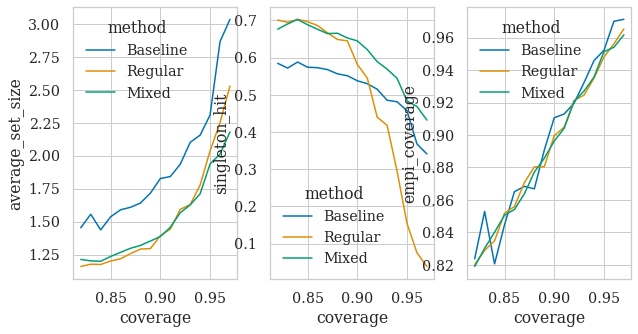

In [18]:
sns.set_theme(context='notebook', style='whitegrid', palette='colorblind', font='serif', font_scale=1.3, color_codes=True, rc=None)
f, axs = plt.subplots(1, 3, figsize=(10, 5))
sns.lineplot(data=transductive_cps, x="coverage", y="average_set_size", hue="method", ax=axs[0])
sns.lineplot(data=transductive_cps, x="coverage", y="singleton_hit", hue="method", ax=axs[1])
sns.lineplot(data=transductive_cps, x="coverage", y="empi_coverage", hue="method", ax=axs[2])

In [19]:
inductive_regular, i_reg_params = find_all_regular_params(instance, dataset, inductive_model, 0.92, tune_idx, n_iterations=20)
inductive_mixing, i_mixing_params = find_all_mixing_params(instance, dataset, inductive_model, 0.92, tune_idx, n_iterations=20)

In [20]:
inductive_cps = []
lambda_val = i_mixing_params[0]
k_reg = i_reg_params[0]
penalty = i_reg_params[1]
for coverage_v in coverage_values:
    c = compare_cps_fair(instance, dataset, inductive_model, coverage_v, lambda_val, k_reg, penalty, calib_fraction, test_idx, tune_idx, n_iters=100)
    c_mean = c["mean"]
    inductive_cps.append(c_mean)
inductive_cps = pd.concat(inductive_cps, keys=coverage_values).reset_index().rename(columns={"level_0": "coverage", "level_1": "method"})

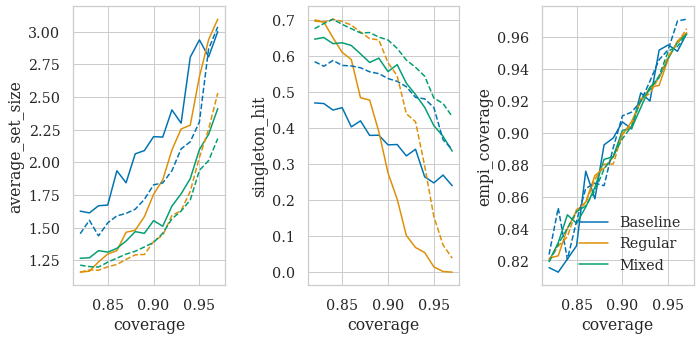

In [21]:
sns.set_theme(context='notebook', style='whitegrid', palette='colorblind', font='serif', font_scale=1.3, color_codes=True, rc=None)
f, axs = plt.subplots(1, 3, figsize=(10, 5))
sns.lineplot(data=inductive_cps, x="coverage", y="average_set_size", hue="method", ax=axs[0])
sns.lineplot(data=inductive_cps, x="coverage", y="singleton_hit", hue="method", ax=axs[1])
sns.lineplot(data=inductive_cps, x="coverage", y="empi_coverage", hue="method", ax=axs[2])

sns.lineplot(data=transductive_cps, x="coverage", y="average_set_size", hue="method", ax=axs[0], linestyle="--")
sns.lineplot(data=transductive_cps, x="coverage", y="singleton_hit", hue="method", ax=axs[1], linestyle="--")
sns.lineplot(data=transductive_cps, x="coverage", y="empi_coverage", hue="method", ax=axs[2], linestyle="--")
axs[0].legend().remove()
axs[1].legend().remove()
handles, labels = axs[2].get_legend_handles_labels()
axs[2].legend(handles[:3], labels[:3])
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "transductive-all-inductive.pgf"), format="pgf", bbox_inches='tight')

### Inductive Case

In [22]:
instance

{'train_idx': tensor([1276,  742, 1650,  499, 1254, 2700, 2614, 2699, 1635, 1691,   50,  918,
         2620,   96, 1644, 2499, 2872, 1253, 2228,  745,   43,   11, 2042, 2804,
         2169, 2858, 1622, 1047, 2920, 1724, 2129, 2159, 2552, 1595,  582, 1203,
         1275, 2145, 2178,  371, 2473, 2472, 1795, 2747, 2533, 1202, 1076, 1038,
         2876, 1667, 1384, 2372, 2694,  438, 2968,  675, 2417,  402, 2502, 2921,
         2729, 1314,  207,  591, 2008,  962,  764,   75, 1450, 1573, 1568,  236,
         2110, 2070, 2569, 2410,  183, 1552,   19, 1681,  775, 1331, 1380,  611,
         2220, 1731, 2366,   74, 1213, 2969,  285, 1564, 2266, 1285, 2237,  175,
          671, 2603, 2713, 1578, 1660, 2635,  326, 1255, 1970, 2246,  536, 2720,
          389, 1732,  411,  713, 2827,  635, 2928, 2540, 1091, 2458, 2303, 2189,
         2714,  242, 2657,  503,  294, 2480,  348, 2310, 2154, 1085,  267,  969,
         1949, 2717, 1446, 1983, 2226,  343, 1260, 1417]),
 'val_idx': tensor([1390,  659, 1822,

In [23]:
# make_inductive_subgraph
train_idx = instances[0]["train_idx"]
val_idx = instances[0]["val_idx"]
test_idx = instances[0]["test_idx"]

calib_idx, eval_idx, calib_mask, eval_mask = dataset_manager.train_test_split(test_idx, F.one_hot(dataset.y[test_idx]).bool(), training_fraction=calib_fraction)

base_cp = GraphCP(transformation_sequence=[cp_t.APSTransformation(softmax=True)], coverage_guarantee=0.92)
idx = torch.concat([train_idx.to(device), val_idx.to(device), calib_idx.to(device)])
calib_dataset = make_subgraph(dataset, idx)
calib_logits = inductive_model.predict(calib_dataset)
calib_scores = base_cp.get_scores_from_logits(calib_logits)
base_cp.calibrate_from_scores(calib_scores[calib_idx], calib_mask)


-0.9713306427001953

In [24]:
eval_pred_list = []
e_idx = idx.clone()
for eval_elem in eval_idx:
    e_idx = torch.concat([e_idx, torch.tensor([eval_elem]).to(device)])
    e_dataset = make_subgraph(dataset, e_idx)
    # print(e_dataset.edge_index.shape[1])
    e_logits = inductive_model.predict(e_dataset)
    e_scores = base_cp.get_scores_from_logits(e_logits)
    pred_set = base_cp.predict_from_scores(e_scores)
    eval_pred_list.append(pred_set[eval_elem])
eval_pred_list = torch.stack(eval_pred_list)

In [25]:
scale=1
final_result = []
for lim in range(1, eval_pred_list.shape[0] // scale):
    final_result.append({
        "index": lim,
        "overall_index" : lim * scale, 
        "coverage": base_cp.coverage(eval_pred_list[:lim * scale], eval_mask[:lim * scale]),
        "batch_coverage": base_cp.coverage(eval_pred_list[(lim-1) *scale:lim *scale], eval_mask[(lim-1) *scale:lim *scale])
    })
final_result = pd.DataFrame(final_result)
baseline_result = final_result

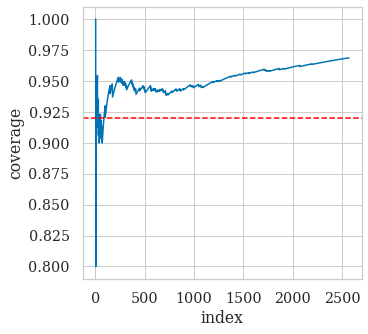

In [26]:
f, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.lineplot(data=final_result, x="index", y="coverage", ax=ax)
ax.axhline(0.92, color="red", linestyle="--")

### Mixing

In [27]:
# make_inductive_subgraph
train_idx = instances[0]["train_idx"]
val_idx = instances[0]["val_idx"]
test_idx = instances[0]["test_idx"]

calib_idx, eval_idx, calib_mask, eval_mask = dataset_manager.train_test_split(test_idx, F.one_hot(dataset.y[test_idx]).bool(), training_fraction=calib_fraction)

idx = torch.concat([train_idx.to(device), val_idx.to(device), calib_idx.to(device)])
calib_dataset = make_subgraph(dataset, idx)
calib_logits = inductive_model.predict(calib_dataset)

mixed_cp = GraphCP(transformation_sequence=[cp_t.APSTransformation(softmax=True), cp_gt.VertexMPTransformation(neigh_coef=0.6, edge_index=calib_dataset.edge_index, n_vertices=dataset.x.shape[0])], coverage_guarantee=0.92)
calib_scores = mixed_cp.get_scores_from_logits(calib_logits)
mixed_cp.calibrate_from_scores(calib_scores[calib_idx], calib_mask)


-0.7435922622680664

In [28]:
eval_pred_list = []
e_idx = idx.clone()
for eval_elem in eval_idx:
    e_idx = torch.concat([e_idx, torch.tensor([eval_elem]).to(device)])
    e_dataset = make_subgraph(dataset, e_idx)
    remixed_cp = GraphCP(transformation_sequence=[cp_t.APSTransformation(softmax=True), cp_gt.VertexMPTransformation(neigh_coef=0.6, edge_index=e_dataset.edge_index, n_vertices=dataset.x.shape[0])], coverage_guarantee=0.92)
    # print(e_dataset.edge_index.shape[1])
    e_logits = inductive_model.predict(e_dataset)
    e_scores = remixed_cp.get_scores_from_logits(e_logits)
    pred_set = mixed_cp.predict_from_scores(e_scores)
    eval_pred_list.append(pred_set[eval_elem])
eval_pred_list = torch.stack(eval_pred_list)

In [29]:
scale = 1
final_result = []
for lim in range(1, eval_pred_list.shape[0] //scale):
    final_result.append({
        "index": lim,
        "overall_index" : lim * scale, 
        "coverage": base_cp.coverage(eval_pred_list[:lim *scale], eval_mask[:lim *scale]),
        "batch_coverage": base_cp.coverage(eval_pred_list[(lim-1) *scale:lim *scale], eval_mask[(lim-1) *scale:lim *scale])
    })
final_result = pd.DataFrame(final_result)
mixing_result = final_result

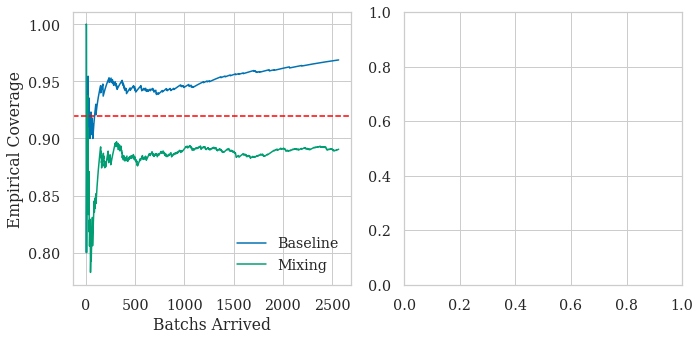

In [30]:
sns.set_theme(context='notebook', style='whitegrid', palette='colorblind', font='serif', font_scale=1.3, color_codes=True, rc=None)
f, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(data=baseline_result, x="overall_index", y="coverage", ax=ax[0], label="Baseline")
sns.lineplot(data=mixing_result, x="overall_index", y="coverage", ax=ax[0], label="Mixing", color="#029E73")
ax[0].axhline(0.92, color="red", linestyle="--")

f.tight_layout()
ax[0].set_xlabel("Batchs Arrived")
ax[0].set_ylabel("Empirical Coverage")
plt.savefig(os.path.join(figures_dir, f"arriving-inductive-scale{scale}.pgf"), format="pgf", bbox_inches='tight')

# Coverage Hist

In [1]:
calib_fraction = 0.1

In [ ]:
instance_idx = 0
instance = instances[instance_idx]
model = instance["model"]
test_idx = instance["test_idx"]
logits = model.predict(dataset)

base_cp = GraphCP(transformation_sequence=[cp_t.APSTransformation(softmax=True)])
base_scores = base_cp.get_scores_from_logits(logits)

result = []
for exp_idx in range(1000):
    calib_idx, eval_idx, calib_mask, eval_mask = dataset_manager.train_test_split(test_idx, F.one_hot(dataset.y[test_idx]).bool(), training_fraction=calib_fraction)
    q_green = base_cp.calibrate_from_scores(base_scores[calib_idx], calib_mask)
    red_alpha = (base_scores[calib_idx][~calib_mask] > q_green).float().mean()
    result.append(
        red_alpha
    )

In [68]:
inductive_cps = []
lambda_val = i_mixing_params[0]
k_reg = i_reg_params[0]
penalty = i_reg_params[1]

coverage_v = 0.90

overall_result = []

for run in range(1000):
    c = compare_cps(instance, dataset, coverage_v, lambda_val, k_reg, penalty, calib_fraction, test_idx, n_iters=1)
    c_mean = c["mean"]
    overall_result.append(c_mean)
overall_result = pd.concat(overall_result, keys = list(range(1000))).reset_index().rename(columns={"level_0": "run", "level_1": "method"})

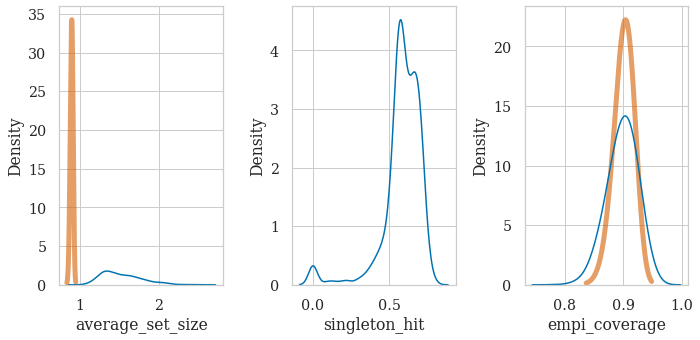

In [71]:
f, axs = plt.subplots(1, 3, figsize=(10, 5))
from scipy.stats import beta
n = int(calib_fraction * len(test_idx))
alpha = 1-coverage_v
l = np.floor((n + 1) * alpha)
a, b = n+1-l, l

x = np.linspace(beta.ppf(0.001, a, b),
                beta.ppf(0.999, a, b), 1000)


n_2 = dataset.y.max().item() * (n + 1)
l_2 = np.floor((n_2 + 1) * alpha_red.cpu().numpy())
a2, b2 = n_2+1-l_2, l_2
x2 = np.linspace(beta.ppf(0.001, a2, b2),
                beta.ppf(0.999, a2, b2), 1000)

axs[2].plot(x, beta.pdf(x, a, b) , 'r-', lw=5, alpha=0.6, label='beta pdf')
axs[0].plot(x, beta.pdf(x, a, b) + beta.pdf(x2, a2, b2) , 'r-', lw=5, alpha=0.6, label='beta pdf')

# plt.hist(emp_dist, density=True, bins=10);

sns.set_theme(context='notebook', style='whitegrid', palette='colorblind', font='serif', font_scale=1.3, color_codes=True, rc=None)

sns.kdeplot(overall_result["average_set_size"], ax=axs[0], bw_adjust=1.1)
sns.kdeplot(overall_result["singleton_hit"],  ax=axs[1],  bw_adjust=1.1)
sns.kdeplot(overall_result["empi_coverage"],  ax=axs[2],  bw_adjust=2.5)
f.tight_layout()

In [ ]:
inductive_cps = []
lambda_val = i_mixing_params[0]
k_reg = i_reg_params[0]
penalty = i_reg_params[1]

coverage_v = 0.92

overall_result = []

for run in range(1000):
    c = compare_cps_fair(instance, dataset, transductive_model, coverage_v, lambda_val, k_reg, penalty, 0.5, test_idx, tune_idx, n_iters=1)
    c_mean = c["mean"]
    overall_result.append(c_mean)
overall_result = pd.concat(overall_result, keys = list(range(10000))).reset_index().rename(columns={"level_0": "run", "level_1": "method"})

# Inductive Case

In [46]:
instance_idx = 0
instance = instances[instance_idx]
model = instance["model"]
test_idx = instance["test_idx"]
logits = model.predict(dataset)

base_cp = GraphCP(transformation_sequence=[cp_t.APSTransformation(softmax=True)], coverage_guarantee=0.95)
base_scores = base_cp.get_scores_from_logits(logits)

mixing_cp = GraphCP(transformation_sequence=[cp_t.APSTransformation(softmax=True), cp_gt.VertexMPTransformation(neigh_coef=0.6, edge_index=dataset.edge_index, n_vertices=dataset.x.shape[0])], coverage_guarantee=0.95)
mixing_scores = mixing_cp.get_scores_from_logits(logits)

raps_cp = GraphCP(transformation_sequence=[cp_t.APSTransformation(softmax=True), cp_t.RegularizerPenalty(k_reg=0, penalty=0.1)], coverage_guarantee=0.95)
raps_scores =  raps_cp.get_scores_from_logits(logits)

aps_no_covered = torch.zeros_like(dataset.y)
mixing_no_covered = torch.zeros_like(dataset.y)
raps_no_covered = torch.zeros_like(dataset.y)

in_eval = torch.zeros_like(dataset.y)
result = []
for exp_idx in range(1000):
    calib_idx, eval_idx, calib_mask, eval_mask = dataset_manager.train_test_split(test_idx, F.one_hot(dataset.y[test_idx]).bool(), training_fraction=calib_fraction)
    q_green = base_cp.calibrate_from_scores(base_scores[calib_idx], calib_mask)
    aps_pred_set = base_cp.predict_from_scores(base_scores[eval_idx])
    
    q_mixed = mixing_cp.calibrate_from_scores(mixing_scores[calib_idx], calib_mask)
    mixing_pred_set = mixing_cp.predict_from_scores(mixing_scores[eval_idx])
    
    
    q_raps = raps_cp.calibrate_from_scores(raps_scores[calib_idx], calib_mask)
    raps_pred_set = raps_cp.predict_from_scores(raps_scores[eval_idx])
    
    aps_no_covered[eval_idx] += aps_pred_set[eval_mask].int()
    mixing_no_covered[eval_idx] += mixing_pred_set[eval_mask].int()
    raps_no_covered[eval_idx] += raps_pred_set[eval_mask].int()
    in_eval[eval_idx] += 1


<AxesSubplot:ylabel='Density'>

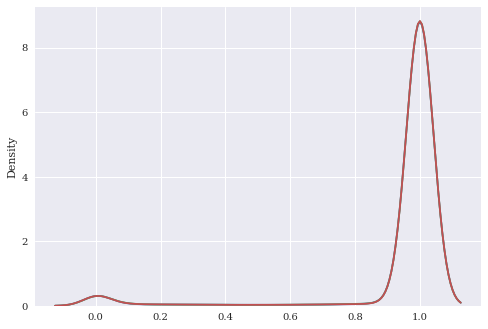

In [47]:
sns.kdeplot((aps_no_covered / in_eval)[test_idx].cpu().numpy())
sns.kdeplot((mixing_no_covered / in_eval)[test_idx].cpu().numpy())
sns.kdeplot((raps_no_covered / in_eval)[test_idx].cpu().numpy())


In [56]:
aps_sorted = (aps_no_covered / in_eval)[test_idx].cpu().numpy()
aps_idx = np.argsort(aps_sorted)

In [60]:
mixing_sorted = (mixing_no_covered / in_eval)[test_idx].cpu().numpy()
raps_sorted = (raps_no_covered / in_eval)[test_idx].cpu().numpy()

In [ ]:
# plt.plot(aps_sorted[aps_idx])
plt.plot(raps_sorted[aps_idx] / aps_sorted[aps_idx])
# plt.plot(mixing_sorted[aps_idx])
plt.ylim(0, 2)

In [ ]:
# plt.plot(aps_sorted[aps_idx])
plt.plot(mixing_sorted[aps_idx] / aps_sorted[aps_idx])
# plt.plot(mixing_sorted[aps_idx])
plt.ylim(0, 2)